In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.combine import SMOTETomek

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")


In [3]:
train.head(3)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0


In [4]:
train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

# EDA 
It is important to understand the data intensly and the business problem. <br>
For each Feature look into the following 
- Mean 
- Class Imbalance 
- Skewness 
- Outliers 
- Correlation to other features 

### We will first do a TSNE plot with the numerical features to get and idea of the complexity of the problem

In [5]:
# numerical_cols = train.select_dtypes(include=['number']).columns  # Select only numerical features

# # Standardize numerical data (important for t-SNE performance)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(train[numerical_cols])

# # Apply t-SNE (reducing to 2D for visualization)
# tsne = TSNE(n_components=2, random_state=42, perplexity=40)
# X_embedded = tsne.fit_transform(X_scaled)

# # Convert to DataFrame
# df_tsne = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'])

In [6]:
# df_tsne['Target'] = train['loan_status']  # Replace 'target_column' with your actual target variable

# # Plot t-SNE result
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='TSNE1', y='TSNE2', hue='Target', palette='viridis', data=df_tsne)
# plt.title('t-SNE Visualization')
# plt.show()

The TSNE plot (even without categorical feats) is pretty well seperated. We expect to perform quite well on this dataset. <br>
At the end we will encode the categorical features as well to see how it affects the graph

In [7]:
def descriptive_table(df):
    """
    Takes in a dataframe with numerical features and returns a decribtive table with some key values for each feature.
    """
    descriptive = df.describe()
    descriptive = descriptive.T

    numerical_cols = df.select_dtypes(include=['number'])
    # Compute skewness and kurtosis
    results = pd.DataFrame({
        'Skewness': numerical_cols.apply(lambda x: skew(x.dropna()), axis=0),
        'Kurtosis': numerical_cols.apply(lambda x: kurtosis(x.dropna()), axis=0)
    })
    return descriptive.merge(results, left_index=True, right_index=True).T

def categorical_descriptive(df):
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    # Store results in a list
    cat_counts_list = []

    for col in categorical_cols:
        value_counts = df[col].value_counts(dropna=False)  # Include NaN values
        temp_df = pd.DataFrame({
            'Category': col,
            'Value': value_counts.index,
            'Count': value_counts.values
        })
        cat_counts_list.append(temp_df)

    # Combine all results into a single DataFrame
    return pd.concat(cat_counts_list, ignore_index=True)

In [8]:
descriptive_num = descriptive_table(train)
descriptive_cat = categorical_descriptive(train)

In [9]:
descriptive_num

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000
Skewness,0.000000,1.965446,1.045746e+01,2.054377,1.188548,0.200015,0.917450,1.618461,2.046796
Kurtosis,-1.200000,6.407731,3.426000e+02,29.129020,1.693537,-0.718194,0.631186,3.490375,2.189374


## Possible Issues 
- person_age: Quite a highe kurtosis, a max age of 123, is this accuarte? 
- person_emp_length: Not sure what this is but way to high kurtosis, investigate for outliers 
- loan_amnt: quite a high std
- loan_percent_income: a value of 0, is this correct?

## Let's investigate all of these issues

### Age

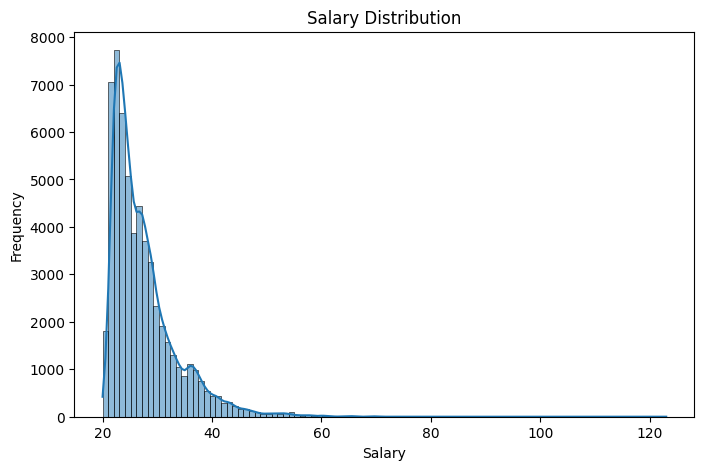

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(train['person_age'], bins=100, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()

Clearly a big tail, this does make intuitive sense, as we expect younger people to need more loans. Lets investigate further

In [11]:
train.nlargest(10, columns=['person_age'])

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
47336,47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
4962,4962,84,108928,MORTGAGE,3.0,DEBTCONSOLIDATION,A,6000,7.51,0.06,N,25,0
6750,6750,84,94800,MORTGAGE,2.0,PERSONAL,D,10000,14.09,0.11,N,22,0
15588,15588,80,54000,RENT,27.0,PERSONAL,A,10000,6.62,0.19,N,25,1
21953,21953,80,30000,RENT,7.0,MEDICAL,D,5000,14.96,0.17,N,24,1
16954,16954,76,30000,RENT,2.0,HOMEIMPROVEMENT,D,6500,16.77,0.21,N,24,1
6425,6425,73,32004,MORTGAGE,3.0,PERSONAL,B,7500,10.65,0.24,N,23,0
24266,24266,73,40000,RENT,0.0,MEDICAL,B,1800,11.36,0.04,N,21,0
25499,25499,73,42000,RENT,7.0,PERSONAL,D,13750,14.96,0.32,N,24,1
5597,5597,70,21600,RENT,0.0,MEDICAL,A,6000,6.99,0.28,N,24,0


Age of 123 is an outlier and we will remove it.

In [12]:
train_cleaned = train[train['person_age'] <= 100]

### person_emp_length
This is a persons employment length

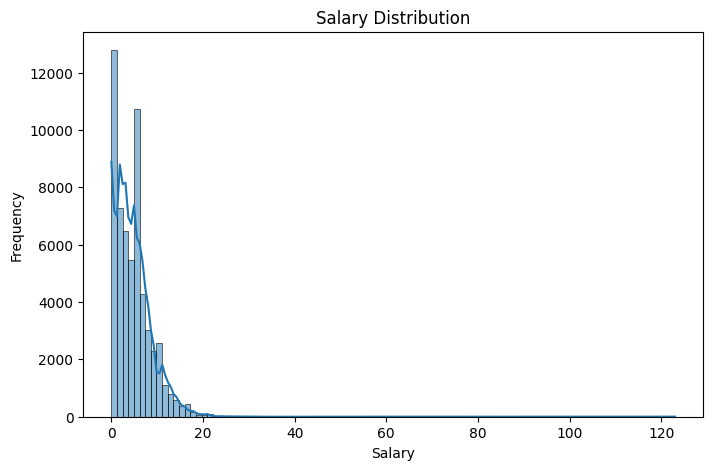

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(train['person_emp_length'], bins=100, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()

In [14]:
train.nlargest(10, columns=['person_emp_length'])

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
41079,41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
49252,49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
9997,9997,58,48000,RENT,41.0,PERSONAL,D,7500,13.55,0.17,Y,24,0
26125,26125,43,56000,RENT,41.0,HOMEIMPROVEMENT,B,2000,10.99,0.04,N,14,0
50559,50559,56,70000,RENT,39.0,MEDICAL,B,8000,11.36,0.11,N,17,0
24214,24214,43,50000,RENT,35.0,DEBTCONSOLIDATION,A,9000,5.42,0.18,N,16,0
29271,29271,47,53913,MORTGAGE,31.0,HOMEIMPROVEMENT,B,7000,10.71,0.13,N,13,1
39112,39112,46,84000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,20000,17.49,0.24,N,8,0
48287,48287,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,A,9000,8.94,0.13,N,8,0
52038,52038,38,42000,MORTGAGE,31.0,VENTURE,B,11000,11.49,0.26,N,14,0


An employment length of 123 is clearly impossible. <br>
Remove all observations for which emp_length > (age - 15). <br>
15 because this is when you can actually start working. Plus this will only remove 50 observations (insignificant considering the amount of observations)

In [15]:
train[train['person_emp_length'] > (train['person_age'] - 15)].shape

(50, 13)

In [16]:
train_cleaned = train_cleaned[train_cleaned['person_emp_length'] <= (train_cleaned['person_age'] - 15)]

### loan_percent_income

#### Person Income

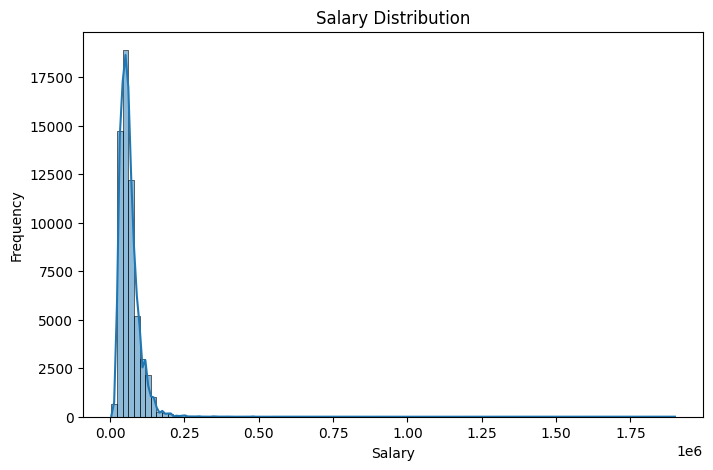

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(train['person_income'], bins=100, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()

Very big tail. Considering most financial systems this is to be expected

In [18]:
train.nlargest(10, columns=['person_income'])

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
17387,17387,22,1900000,MORTGAGE,6.0,EDUCATION,D,1500,15.62,0.00,Y,3,0
12404,12404,25,1839784,RENT,0.0,VENTURE,A,8000,8.00,0.04,N,3,0
37591,37591,29,1824000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,6000,13.99,0.03,N,6,0
2093,2093,32,1200000,RENT,2.0,PERSONAL,A,10000,7.51,0.01,N,9,0
19060,19060,32,1200000,MORTGAGE,16.0,DEBTCONSOLIDATION,A,16000,6.92,0.13,N,5,0
11422,11422,29,948000,OWN,11.0,PERSONAL,B,4000,11.83,0.04,N,5,0
34752,34752,27,928000,MORTGAGE,8.0,VENTURE,C,2850,13.92,0.01,N,7,0
18465,18465,32,900000,RENT,13.0,PERSONAL,B,25000,11.49,0.03,N,5,0
31446,31446,26,900000,MORTGAGE,3.0,VENTURE,B,6000,9.91,0.01,N,3,0
37902,37902,35,900000,MORTGAGE,18.0,PERSONAL,B,4500,10.65,0.01,N,6,0


These values seem extremely large but cannot be declared as outliers as they are not completely beyond the scope of reality. <br>
Will definitely consider removing it

In [19]:
train.nsmallest(10, columns=['loan_percent_income'])

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
17387,17387,22,1900000,MORTGAGE,6.0,EDUCATION,D,1500,15.62,0.00,Y,3,0
50049,50049,24,30000,MORTGAGE,1.0,DEBTCONSOLIDATION,A,3200,8.07,0.00,N,4,0
91,91,24,225000,RENT,0.0,MEDICAL,C,3000,14.26,0.01,Y,2,0
677,677,30,100000,MORTGAGE,7.0,EDUCATION,A,1200,8.32,0.01,N,8,0
2093,2093,32,1200000,RENT,2.0,PERSONAL,A,10000,7.51,0.01,N,9,0
2298,2298,37,780000,RENT,9.0,HOMEIMPROVEMENT,B,7500,12.18,0.01,N,7,0
3330,3330,23,97000,RENT,0.0,DEBTCONSOLIDATION,A,1350,8.94,0.01,N,2,0
4168,4168,26,183000,MORTGAGE,8.0,DEBTCONSOLIDATION,A,2000,7.37,0.01,N,2,0
4387,4387,27,73000,RENT,3.0,PERSONAL,A,1000,8.59,0.01,N,8,0
4516,4516,29,76000,RENT,1.0,HOMEIMPROVEMENT,B,1000,11.71,0.01,N,5,0


In [20]:
train.nlargest(10, columns=['loan_percent_income'])


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
49179,49179,39,12000,RENT,0.0,PERSONAL,C,16000,10.78,0.83,N,12,1
56034,56034,35,40000,OWN,1.0,HOMEIMPROVEMENT,B,25000,11.86,0.63,N,8,0
54980,54980,22,69000,RENT,0.0,VENTURE,D,3775,18.25,0.59,N,4,1
21747,21747,36,18000,RENT,0.0,HOMEIMPROVEMENT,E,12000,18.39,0.56,Y,12,1
44806,44806,40,14400,RENT,2.0,HOMEIMPROVEMENT,C,8000,14.27,0.56,N,15,1
37533,37533,35,54500,MORTGAGE,19.0,DEBTCONSOLIDATION,B,30000,9.91,0.55,N,5,0
51057,51057,58,13200,RENT,2.0,VENTURE,D,7000,8.49,0.54,N,21,1
25759,25759,26,47000,OWN,2.0,EDUCATION,B,25000,11.11,0.53,N,4,0
37014,37014,39,40000,OWN,0.0,PERSONAL,A,21000,6.17,0.53,N,13,0
53404,53404,44,47000,OWN,14.0,HOMEIMPROVEMENT,A,24000,6.99,0.53,N,13,0


There seems to have been come mistake with the calculation of the percent variable. The smallest and largest values are both incorrect. Lets recalculate the variable.

In [21]:
train_cleaned['loan_percent_income'] = train_cleaned['loan_percent_income'].astype(dtype=float)
train_cleaned.loc[:,'loan_percent_income'] = (train_cleaned['loan_amnt'].astype(dtype=float) / train_cleaned['person_income'].astype(dtype=float)).astype(dtype=float)

### loan_amnt

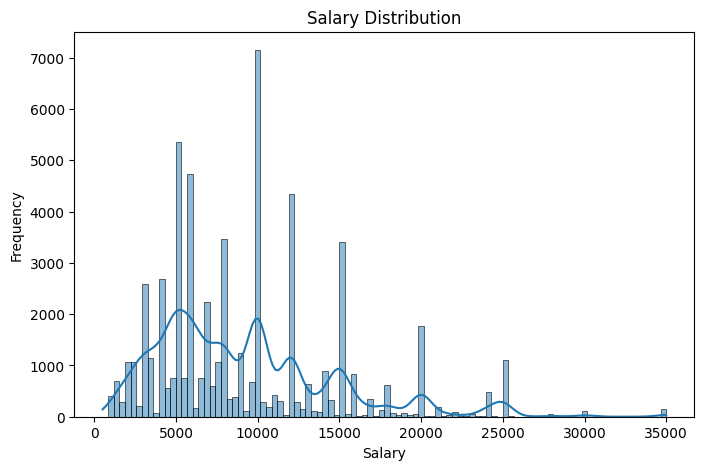

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(train['loan_amnt'], bins=100, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()

In [23]:
train.nlargest(200, columns=['loan_amnt'])

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
249,249,29,100000,MORTGAGE,6.0,DEBTCONSOLIDATION,C,35000,12.73,0.35,Y,8,0
744,744,23,108000,RENT,3.0,VENTURE,D,35000,15.62,0.32,N,2,1
837,837,24,104000,MORTGAGE,8.0,MEDICAL,C,35000,14.27,0.34,Y,4,0
932,932,23,85000,MORTGAGE,7.0,EDUCATION,B,35000,10.65,0.39,N,2,0
967,967,35,150000,RENT,19.0,PERSONAL,E,35000,18.39,0.23,Y,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16672,16672,26,78000,RENT,10.0,VENTURE,B,30000,10.99,0.38,N,3,1
17088,17088,24,54400,RENT,0.0,MEDICAL,E,30000,19.42,0.45,N,2,1
17431,17431,38,150000,MORTGAGE,5.0,DEBTCONSOLIDATION,B,30000,10.37,0.20,N,15,0
17459,17459,29,105000,MORTGAGE,8.0,HOMEIMPROVEMENT,B,30000,11.11,0.29,N,9,0


35000 seems the be the max amount to borrow. We cannot really remove these observation. It has about 150 (thats too big)

In [24]:
descriptive_cat

,Category,Value,Count
0,person_home_ownership,RENT,30594
1,person_home_ownership,MORTGAGE,24824
2,person_home_ownership,OWN,3138
3,person_home_ownership,OTHER,89
4,loan_intent,EDUCATION,12271
5,loan_intent,MEDICAL,10934
6,loan_intent,PERSONAL,10016
7,loan_intent,VENTURE,10011
8,loan_intent,DEBTCONSOLIDATION,9133
9,loan_intent,HOMEIMPROVEMENT,6280


## Possible Issues
- loan_grade: Lower grades are very under represented, maybe grouping E,F and G together?
- cb_person_default_on_file: Imbalances class 
- person_home_ownership: Imbalance


## person_home_ownership

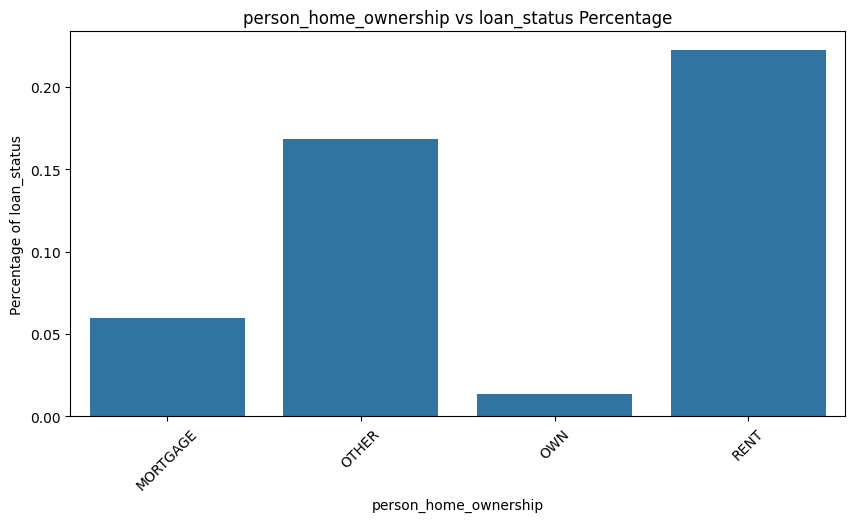

In [25]:
categorical_col = 'person_home_ownership'
target_col = 'loan_status'

# Compute percentage of the target variable per category
category_target_percentage = (
    train.groupby(categorical_col)[target_col]
    .mean()  # Mean gives the proportion of 1s if target is binary (0/1)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=categorical_col, y=target_col, data=category_target_percentage)

# Labels and title
plt.ylabel(f'Percentage of {target_col}')
plt.xlabel(categorical_col)
plt.title(f'{categorical_col} vs {target_col} Percentage')
plt.xticks(rotation=45)  # Rotate if categories are long
plt.show()

Unsure what to do here. OWN is clearly very informative but is under represented. Maybe join with mortgage? <br>
Other is completely under represented and can be joined with rent

In [26]:
train_cleaned['person_home_ownership'] = train_cleaned['person_home_ownership'].replace('OTHER', 'RENT')
test['person_home_ownership'] = test['person_home_ownership'].replace('OTHER', 'RENT')


In [27]:
train_cleaned = pd.get_dummies(train_cleaned, columns=['person_home_ownership'], drop_first=False)
test = pd.get_dummies(test, columns=['person_home_ownership'], drop_first=False)


## cb_person_default_on_file
Wether this person have defaulted in the past 

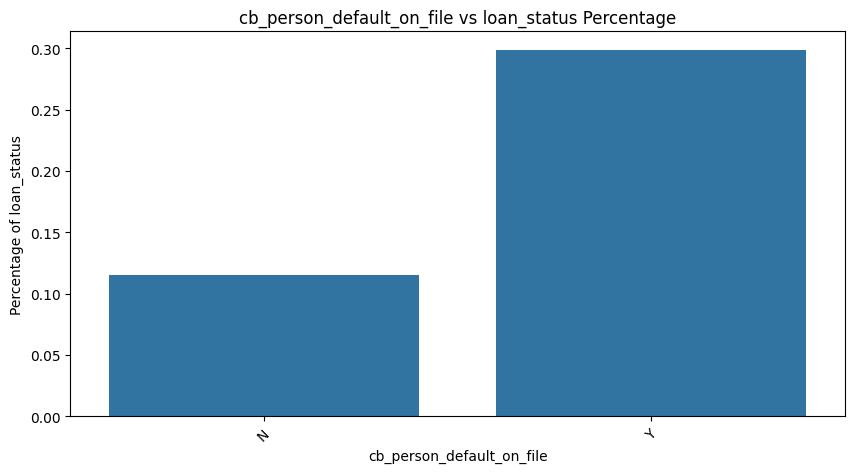

In [28]:

categorical_col = 'cb_person_default_on_file'
target_col = 'loan_status'

# Compute percentage of the target variable per category
category_target_percentage = (
    train.groupby(categorical_col)[target_col]
    .mean()  # Mean gives the proportion of 1s if target is binary (0/1)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=categorical_col, y=target_col, data=category_target_percentage)

# Labels and title
plt.ylabel(f'Percentage of {target_col}')
plt.xlabel(categorical_col)
plt.title(f'{categorical_col} vs {target_col} Percentage')
plt.xticks(rotation=45)  # Rotate if categories are long
plt.show()

Encode with a binary variable. Will be better distributed once the loan status imbalance is either fixed or handled in the algorithm

In [29]:
train_cleaned['cb_person_default_on_file'] = train_cleaned['cb_person_default_on_file'].map({'N': 0, 'Y': 1})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'N': 0, 'Y': 1})


## Loan Intent

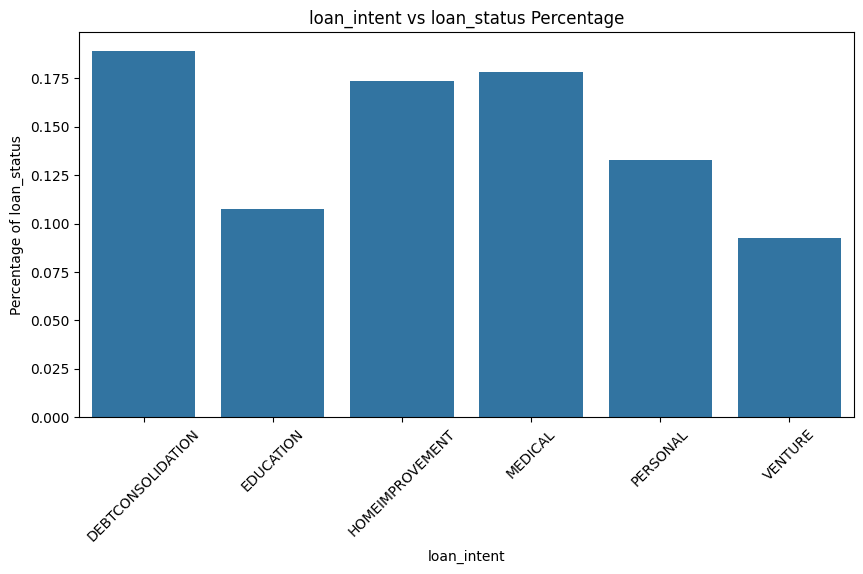

In [30]:
categorical_col = 'loan_intent'
target_col = 'loan_status'

# Compute percentage of the target variable per category
category_target_percentage = (
    train.groupby(categorical_col)[target_col]
    .mean()  # Mean gives the proportion of 1s if target is binary (0/1)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=categorical_col, y=target_col, data=category_target_percentage)

# Labels and title
plt.ylabel(f'Percentage of {target_col}')
plt.xlabel(categorical_col)
plt.title(f'{categorical_col} vs {target_col} Percentage')
plt.xticks(rotation=45)  # Rotate if categories are long
plt.show()

Dummy variables is sufficient for this feature. Can't really be removed as it does encode at least some info

In [31]:
train_cleaned = pd.get_dummies(train_cleaned, columns=['loan_intent'], drop_first=False)
test = pd.get_dummies(test, columns=['loan_intent'], drop_first=False)


## Loan Grade

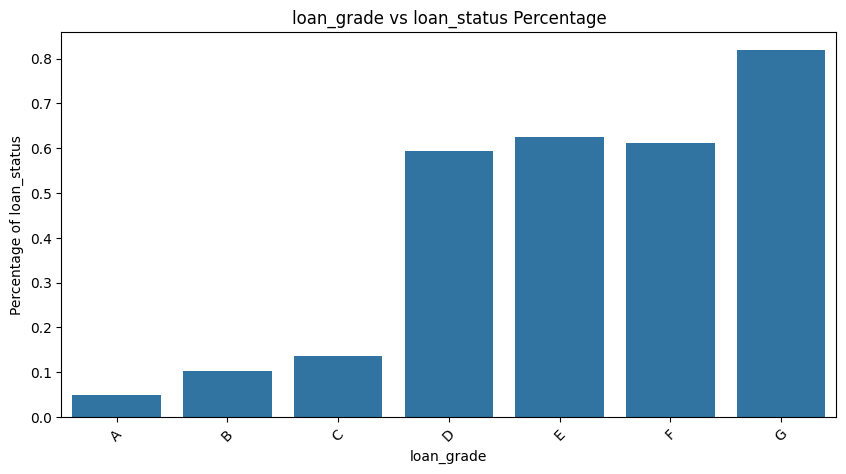

In [32]:
categorical_col = 'loan_grade'
target_col = 'loan_status'

# Compute percentage of the target variable per category
category_target_percentage = (
    train.groupby(categorical_col)[target_col]
    .mean()  # Mean gives the proportion of 1s if target is binary (0/1)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=categorical_col, y=target_col, data=category_target_percentage)

# Labels and title
plt.ylabel(f'Percentage of {target_col}')
plt.xlabel(categorical_col)
plt.title(f'{categorical_col} vs {target_col} Percentage')
plt.xticks(rotation=45)  # Rotate if categories are long
plt.show()

Encode this with numerical values as they indicate a rank. They go in order. <br>
Also DEFG all grouped to improve imbalance

In [33]:
rank_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

train_cleaned['loan_grade'] = train_cleaned['loan_grade'].map(rank_mapping)
test['loan_grade'] = test['loan_grade'].map(rank_mapping)


In [34]:
categorical_cols = train_cleaned.select_dtypes(exclude=['number']).columns
train_cleaned[categorical_cols] = train_cleaned[categorical_cols].astype(int)  
categorical_cols = test.select_dtypes(exclude=['number']).columns
test[categorical_cols] = test[categorical_cols].astype(int)  

train_cleaned.head()

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,37,35000,0.0,2,6000,11.49,0.171429,0,14,0,0,0,1,0,1,0,0,0,0
1,1,22,56000,6.0,3,4000,13.35,0.071429,0,2,0,0,1,0,0,0,0,1,0,0
2,2,29,28800,8.0,1,6000,8.90,0.208333,0,10,0,0,1,0,0,0,0,0,1,0
3,3,30,70000,14.0,2,12000,11.11,0.171429,0,5,0,0,0,1,0,0,0,0,0,1
4,4,22,60000,2.0,1,6000,6.92,0.100000,0,3,0,0,0,1,0,0,0,1,0,0


In [35]:
clean_descriptive = descriptive_table(train_cleaned)


In [36]:
clean_descriptive

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
count,58594.000000,58594.000000,5.859400e+04,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000,58594.000000
mean,29319.161075,27.548230,6.404407e+04,4.686777,2.066611,9215.826740,10.677721,0.159758,0.148360,5.813428,0.142335,0.423200,0.053487,0.523313,0.155733,0.209305,0.107144,0.186401,0.170785,0.170632
std,16929.444426,6.020216,3.793611e+04,3.879072,1.046094,5562.215785,3.034334,0.094258,0.355459,4.029063,0.349397,0.494071,0.225004,0.499460,0.362605,0.406816,0.309299,0.389434,0.376325,0.376190
min,0.000000,20.000000,4.200000e+03,0.000000,1.000000,500.000000,5.420000,0.000789,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14654.250000,23.000000,4.200000e+04,2.000000,1.000000,5000.000000,7.880000,0.089286,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29318.500000,26.000000,5.800000e+04,4.000000,2.000000,8000.000000,10.750000,0.142222,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43977.750000,30.000000,7.560000e+04,7.000000,3.000000,12000.000000,12.990000,0.209302,0.000000,8.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58644.000000,84.000000,1.900000e+06,41.000000,7.000000,35000.000000,23.220000,3.125000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Skewness,0.000217,1.912038,1.046172e+01,1.170054,0.869318,1.189081,0.199994,1.918628,1.978527,1.619017,2.047344,0.310888,3.968973,-0.093353,1.898873,1.429137,2.540321,1.610551,1.749646,1.751088
Kurtosis,-1.199943,5.419487,3.427179e+02,2.030117,0.356871,1.696931,-0.717936,27.997639,1.914571,3.493947,2.191616,-1.903349,13.752744,-1.991285,1.605719,0.042433,4.453229,0.593876,1.061262,1.066309


In [37]:
descriptive_num

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000
Skewness,0.000000,1.965446,1.045746e+01,2.054377,1.188548,0.200015,0.917450,1.618461,2.046796
Kurtosis,-1.200000,6.407731,3.426000e+02,29.129020,1.693537,-0.718194,0.631186,3.490375,2.189374


In [38]:
train_cleaned

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,37,35000,0.0,2,6000,11.49,0.171429,0,14,0,0,0,1,0,1,0,0,0,0
1,1,22,56000,6.0,3,4000,13.35,0.071429,0,2,0,0,1,0,0,0,0,1,0,0
2,2,29,28800,8.0,1,6000,8.90,0.208333,0,10,0,0,1,0,0,0,0,0,1,0
3,3,30,70000,14.0,2,12000,11.11,0.171429,0,5,0,0,0,1,0,0,0,0,0,1
4,4,22,60000,2.0,1,6000,6.92,0.100000,0,3,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,5.0,4,25000,15.95,0.208333,1,10,0,1,0,0,0,1,0,0,0,0
58641,58641,28,28800,0.0,3,10000,12.73,0.347222,0,8,1,0,0,1,0,0,0,1,0,0
58642,58642,23,44000,7.0,4,6800,16.00,0.154545,0,2,1,0,0,1,0,1,0,0,0,0
58643,58643,22,30000,2.0,1,5000,8.90,0.166667,0,3,0,0,0,1,0,1,0,0,0,0


In [39]:
correlation_matrix = train_cleaned.corr()

# Get correlation of all columns with 'loan_status'
loan_status_corr = correlation_matrix['loan_status'].sort_values(ascending=False)

In [40]:
loan_status_corr

loan_status                       1.000000
loan_grade                        0.386184
loan_percent_income               0.375687
loan_int_rate                     0.339108
person_home_ownership_RENT        0.240250
cb_person_default_on_file         0.187120
loan_amnt                         0.144690
loan_intent_DEBTCONSOLIDATION     0.057547
loan_intent_MEDICAL               0.048844
loan_intent_HOMEIMPROVEMENT       0.031178
person_age                       -0.001032
cb_person_cred_hist_length       -0.003140
id                               -0.008014
loan_intent_PERSONAL             -0.012247
loan_intent_EDUCATION            -0.050862
loan_intent_VENTURE              -0.064413
person_home_ownership_OWN        -0.087506
person_emp_length                -0.103959
person_income                    -0.170195
person_home_ownership_MORTGAGE   -0.203020
Name: loan_status, dtype: float64

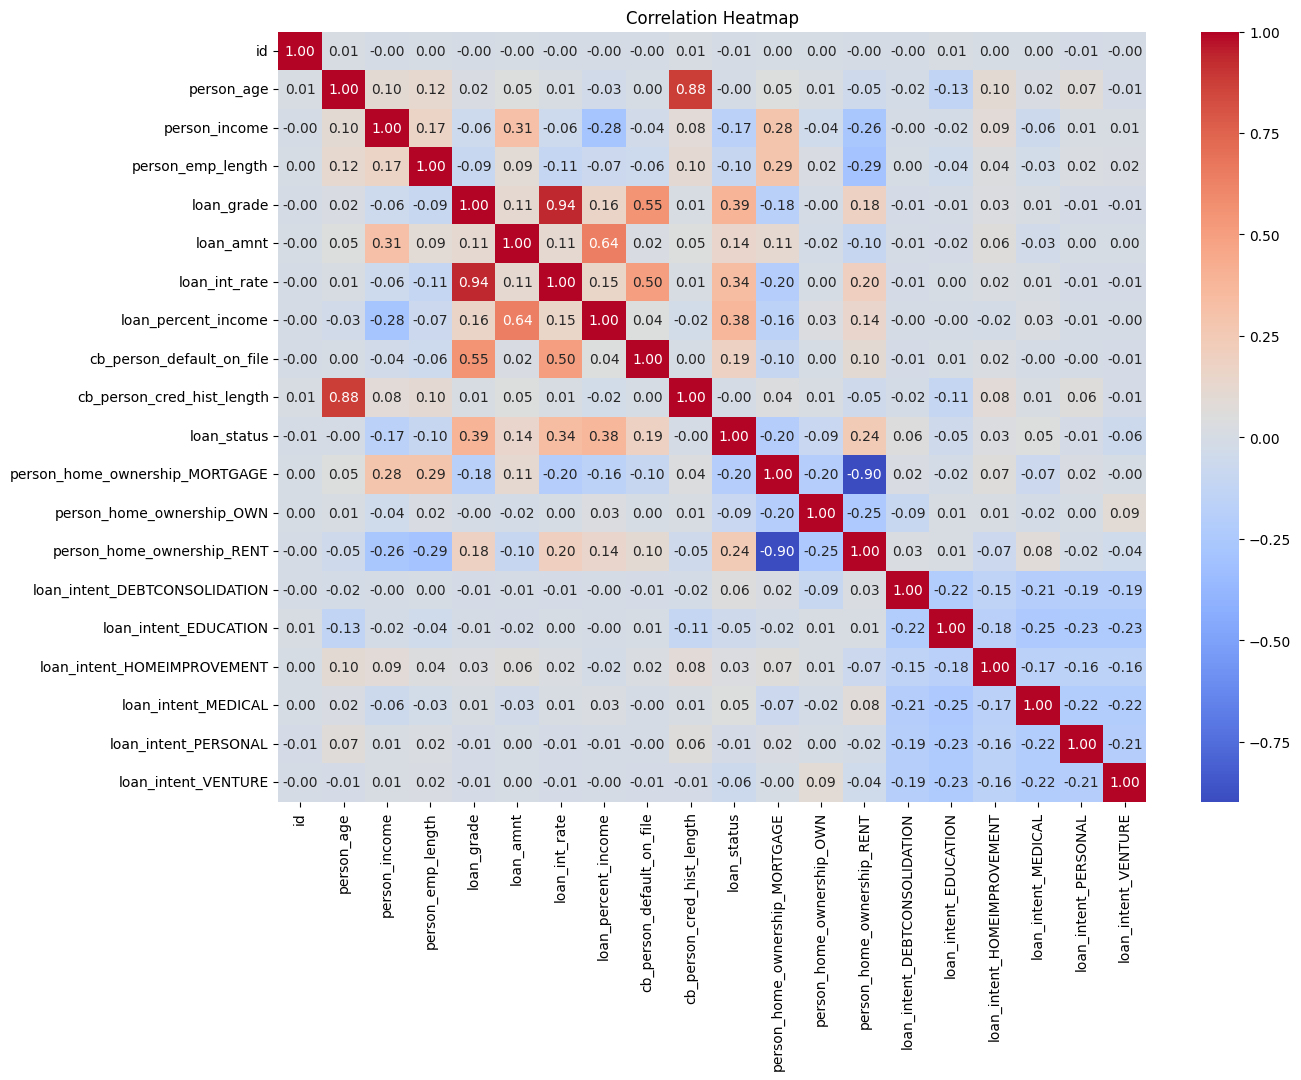

In [41]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Age and cred hist are very correlated to each other and have almost no correlation to the loan status. Only credit history has to be kept. <br>
Interesting age and employment length has a very low correlation. Let's try and engineer some features

In [42]:
train_eng_feats = train_cleaned

In [43]:
train_eng_feats.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')

In [44]:
train_eng_feats['perc_unemployed'] = (train_eng_feats['person_age'] - train_eng_feats['person_emp_length']).astype(float) / train_eng_feats['person_age'].astype(float)
train_eng_feats['after_retirement'] = (train_eng_feats['person_age'] > 65).astype(int)
train_eng_feats['interest_of_income'] = (train_eng_feats['loan_int_rate'] * train_eng_feats['loan_amnt']) / (train_eng_feats['person_income'].astype(float))


In [45]:
test['perc_unemployed'] = (test['person_age'] - test['person_emp_length']).astype(float) / test['person_age'].astype(float)
test['after_retirement'] = (test['person_age'] > 65).astype(int)
test['interest_of_income'] = (test['loan_int_rate'] * test['loan_amnt']) / (test['person_income'].astype(float))

In [46]:
correlation_matrix = train_eng_feats.corr()

# Get correlation of all columns with 'loan_status'
loan_status_corr = correlation_matrix['loan_status'].sort_values(ascending=False)
loan_status_corr


loan_status                       1.000000
interest_of_income                0.457792
loan_grade                        0.386184
loan_percent_income               0.375687
loan_int_rate                     0.339108
person_home_ownership_RENT        0.240250
cb_person_default_on_file         0.187120
loan_amnt                         0.144690
perc_unemployed                   0.108898
loan_intent_DEBTCONSOLIDATION     0.057547
loan_intent_MEDICAL               0.048844
loan_intent_HOMEIMPROVEMENT       0.031178
after_retirement                  0.004035
person_age                       -0.001032
cb_person_cred_hist_length       -0.003140
id                               -0.008014
loan_intent_PERSONAL             -0.012247
loan_intent_EDUCATION            -0.050862
loan_intent_VENTURE              -0.064413
person_home_ownership_OWN        -0.087506
person_emp_length                -0.103959
person_income                    -0.170195
person_home_ownership_MORTGAGE   -0.203020
Name: loan_

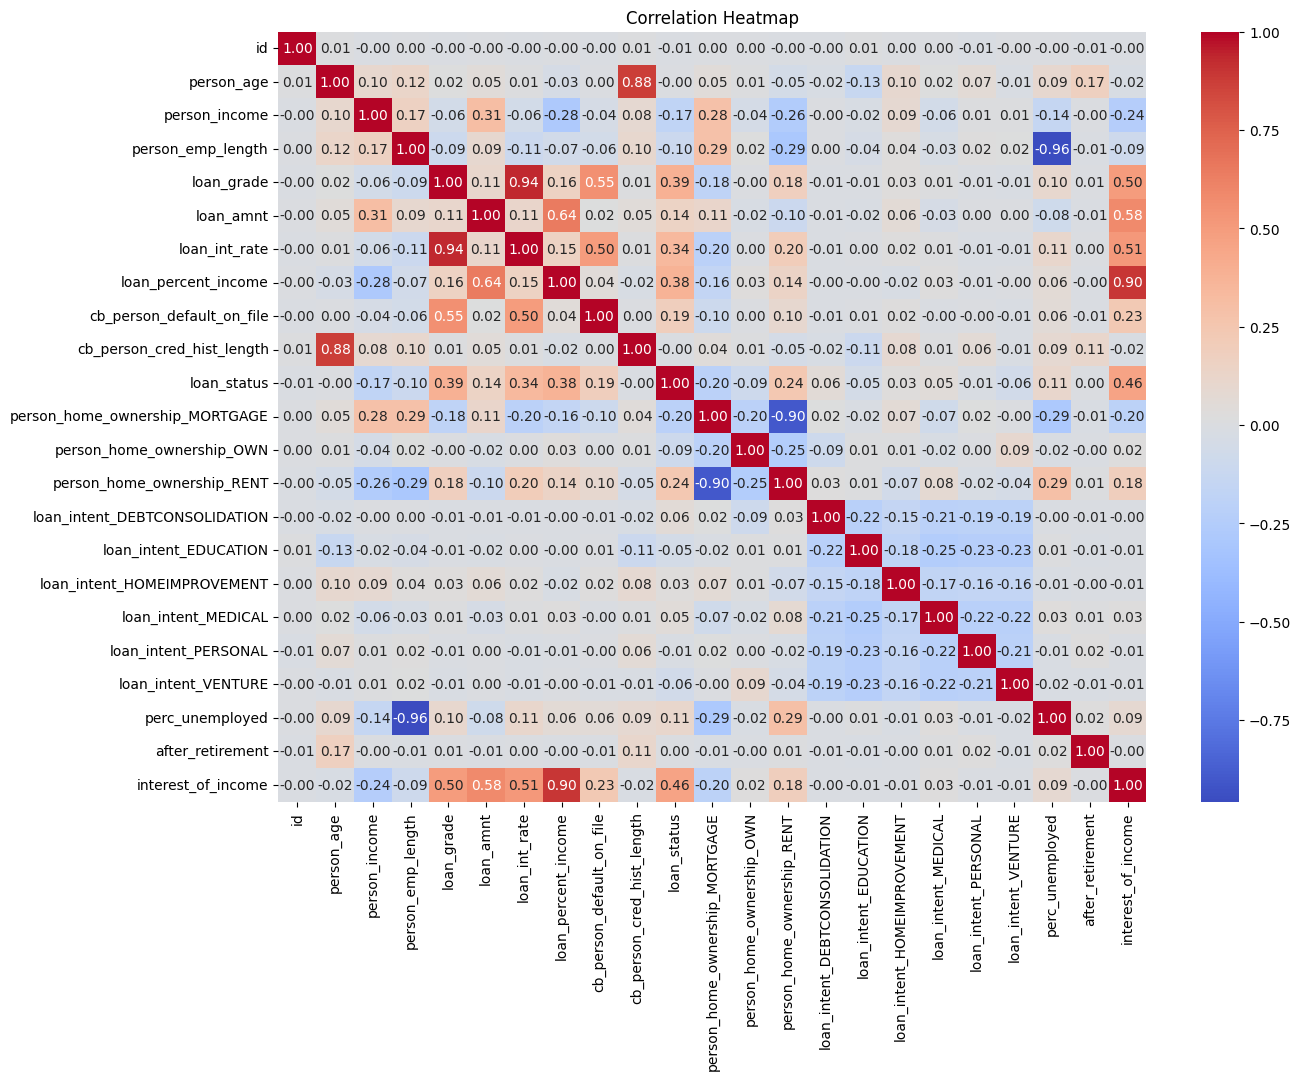

In [47]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [48]:
train_eng_feats.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'perc_unemployed',
       'after_retirement', 'interest_of_income'],
      dtype='object')

Feature Engineering with the 50/30/20 rule <br>
HOMEIMPROVEMENT = 10 <br>
Medical = 25 <br>
Educational = 10 https://files.consumerfinance.gov/f/documents/cfpb_building_block_activities_understanding-how-much-student-debt-afford_guide.pdf?utm_source=chatgpt.com <br>
Debtconsolidation = 36 <br>
Personal = 15 <br>

In [49]:
train_eng_feats.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'perc_unemployed',
       'after_retirement', 'interest_of_income'],
      dtype='object')

In [50]:
train_eng_feats

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,perc_unemployed,after_retirement,interest_of_income
0,0,37,35000,0.0,2,6000,11.49,0.171429,0,14,...,1,0,1,0,0,0,0,1.000000,0,1.969714
1,1,22,56000,6.0,3,4000,13.35,0.071429,0,2,...,0,0,0,0,1,0,0,0.727273,0,0.953571
2,2,29,28800,8.0,1,6000,8.90,0.208333,0,10,...,0,0,0,0,0,1,0,0.724138,0,1.854167
3,3,30,70000,14.0,2,12000,11.11,0.171429,0,5,...,1,0,0,0,0,0,1,0.533333,0,1.904571
4,4,22,60000,2.0,1,6000,6.92,0.100000,0,3,...,1,0,0,0,1,0,0,0.909091,0,0.692000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,5.0,4,25000,15.95,0.208333,1,10,...,0,0,1,0,0,0,0,0.852941,0,3.322917
58641,58641,28,28800,0.0,3,10000,12.73,0.347222,0,8,...,1,0,0,0,1,0,0,1.000000,0,4.420139
58642,58642,23,44000,7.0,4,6800,16.00,0.154545,0,2,...,1,0,1,0,0,0,0,0.695652,0,2.472727
58643,58643,22,30000,2.0,1,5000,8.90,0.166667,0,3,...,1,0,1,0,0,0,0,0.909091,0,1.483333


In [51]:
conditions = (
    ((train_cleaned['loan_intent_MEDICAL'] == 1) & (train_cleaned['loan_percent_income'] > 0.25)) |
    ((train_cleaned['loan_intent_HOMEIMPROVEMENT'] == 1) & (train_cleaned['loan_percent_income'] > 0.15)) |
    ((train_cleaned['loan_intent_DEBTCONSOLIDATION'] == 1) & (train_cleaned['loan_percent_income'] > 0.36)) |
    ((train_cleaned['loan_intent_EDUCATION'] == 1) & (train_cleaned['loan_percent_income'] > 0.10)) |
    ((train_cleaned['loan_intent_PERSONAL'] == 1) & (train_cleaned['loan_percent_income'] > 0.15))
)

# Assign 1 if any condition is met, otherwise 0
train_cleaned['bad_practice'] = conditions.astype(int)

In [52]:
conditions = (
    ((test['loan_intent_MEDICAL'] == 1) & (test['loan_percent_income'] > 0.25)) |
    ((test['loan_intent_HOMEIMPROVEMENT'] == 1) & (test['loan_percent_income'] > 0.15)) |
    ((test['loan_intent_DEBTCONSOLIDATION'] == 1) & (test['loan_percent_income'] > 0.36)) |
    ((test['loan_intent_EDUCATION'] == 1) & (test['loan_percent_income'] > 0.10)) |
    ((test['loan_intent_PERSONAL'] == 1) & (test['loan_percent_income'] > 0.15))
)

# Assign 1 if any condition is met, otherwise 0
test['bad_practice'] = conditions.astype(int)

In [53]:
train_cleaned[train_cleaned['bad_practice'] == 1]

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,perc_unemployed,after_retirement,interest_of_income,bad_practice
0,0,37,35000,0.0,2,6000,11.49,0.171429,0,14,...,0,1,0,0,0,0,1.000000,0,1.969714,1
2,2,29,28800,8.0,1,6000,8.90,0.208333,0,10,...,0,0,0,0,1,0,0.724138,0,1.854167,1
6,6,25,45000,9.0,1,12000,6.54,0.266667,0,3,...,0,1,0,0,0,0,0.640000,0,1.744000,1
11,11,22,33000,6.0,2,10000,11.12,0.303030,0,2,...,0,0,0,0,1,0,0.727273,0,3.369697,1
12,12,25,33000,1.0,2,4000,10.75,0.121212,0,3,...,0,1,0,0,0,0,0.960000,0,1.303030,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58636,58636,24,37000,3.0,3,9000,13.49,0.243243,1,2,...,0,1,0,0,0,0,0.875000,0,3.281351,1
58640,58640,34,120000,5.0,4,25000,15.95,0.208333,1,10,...,0,1,0,0,0,0,0.852941,0,3.322917,1
58641,58641,28,28800,0.0,3,10000,12.73,0.347222,0,8,...,0,0,0,1,0,0,1.000000,0,4.420139,1
58642,58642,23,44000,7.0,4,6800,16.00,0.154545,0,2,...,0,1,0,0,0,0,0.695652,0,2.472727,1


In [54]:
correlation_matrix = train_eng_feats.corr()

# Get correlation of all columns with 'loan_status'
loan_status_corr = correlation_matrix['loan_status'].sort_values(ascending=False)
loan_status_corr

loan_status                       1.000000
interest_of_income                0.457792
loan_grade                        0.386184
loan_percent_income               0.375687
loan_int_rate                     0.339108
person_home_ownership_RENT        0.240250
cb_person_default_on_file         0.187120
bad_practice                      0.160964
loan_amnt                         0.144690
perc_unemployed                   0.108898
loan_intent_DEBTCONSOLIDATION     0.057547
loan_intent_MEDICAL               0.048844
loan_intent_HOMEIMPROVEMENT       0.031178
after_retirement                  0.004035
person_age                       -0.001032
cb_person_cred_hist_length       -0.003140
id                               -0.008014
loan_intent_PERSONAL             -0.012247
loan_intent_EDUCATION            -0.050862
loan_intent_VENTURE              -0.064413
person_home_ownership_OWN        -0.087506
person_emp_length                -0.103959
person_income                    -0.170195
person_home

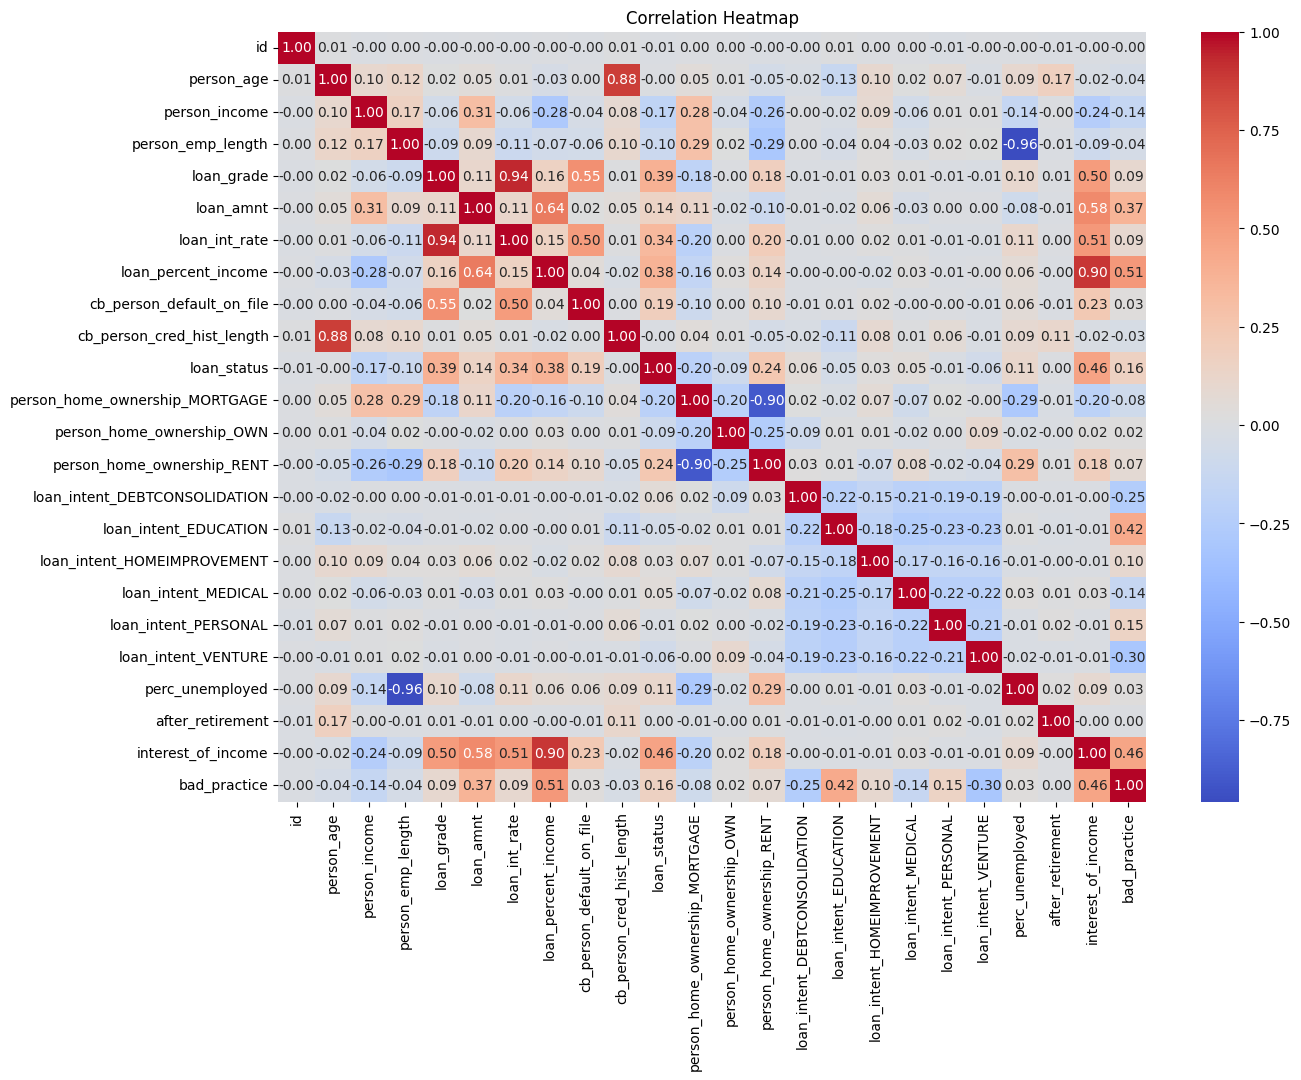

In [55]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [56]:
train.head(1)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0


# Possible features to be engineered
- Years unemployed 
- Years past retirement
- Interest payable (the amount of the first round of interest) % of income 

In [57]:
train_cleaned['loan_status'].value_counts()

loan_status
0    50254
1     8340
Name: count, dtype: int64

In [58]:
train_cleaned.columns

Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'loan_status', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'perc_unemployed',
       'after_retirement', 'interest_of_income', 'bad_practice'],
      dtype='object')

In [59]:
train_eng_feats.to_csv("../data/cleaned_train.csv", index=False)
test.to_csv("../data/cleaned_test.csv", index=False)


/var/folders/_v/wtqndz5s2cqc5nfy735t040h0000gn/T/ipykernel_16084/1417761675.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby('income_bins')[target_col]


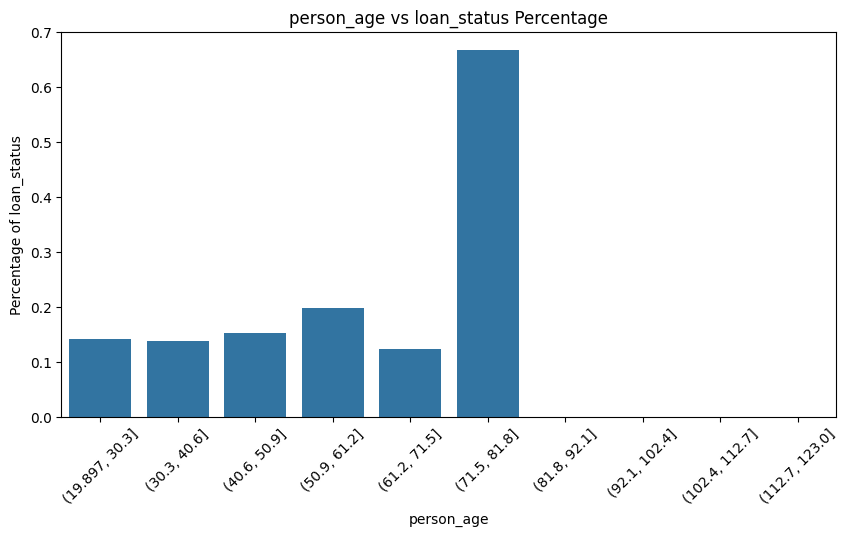

In [60]:
# Define numerical column and target variable
numerical_col = 'person_age'  # Change this to your numerical column
target_col = 'loan_status'

# Bin the numerical feature into categories (adjust bins as needed)
train['income_bins'] = pd.cut(train[numerical_col], bins=10)  # 10 equal-width bins

# Compute percentage of the target variable per bin
category_target_percentage = (
    train.groupby('income_bins')[target_col]
    .mean()  # Mean gives the proportion of 1s if target is binary (0/1)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='income_bins', y=target_col, data=category_target_percentage)

# Labels and title
plt.ylabel(f'Percentage of {target_col}')
plt.xlabel(numerical_col)
plt.title(f'{numerical_col} vs {target_col} Percentage')
plt.xticks(rotation=45)  # Rotate bins if needed
plt.show()

In [72]:
train_eng_feats['old'] = ((train_eng_feats['person_age'] > 71) & (train_eng_feats['person_age']< 81)).astype(int)

In [73]:
train_eng_feats['old']

0        0
1        0
2        0
3        0
4        0
        ..
58640    0
58641    0
58642    0
58643    0
58644    0
Name: old, Length: 58594, dtype: int64

In [74]:
correlation_matrix = train_eng_feats.corr()

# Get correlation of all columns with 'loan_status'
loan_status_corr = correlation_matrix['loan_status'].sort_values(ascending=False)
loan_status_corr

loan_status                       1.000000
interest_of_income                0.457792
loan_grade                        0.386184
loan_percent_income               0.375687
loan_int_rate                     0.339108
person_home_ownership_RENT        0.240250
cb_person_default_on_file         0.187120
bad_practice                      0.160964
loan_amnt                         0.144690
perc_unemployed                   0.108898
loan_intent_DEBTCONSOLIDATION     0.057547
loan_intent_MEDICAL               0.048844
loan_intent_HOMEIMPROVEMENT       0.031178
old                               0.015187
after_retirement                  0.004035
person_age                       -0.001032
cb_person_cred_hist_length       -0.003140
id                               -0.008014
loan_intent_PERSONAL             -0.012247
loan_intent_EDUCATION            -0.050862
loan_intent_VENTURE              -0.064413
person_home_ownership_OWN        -0.087506
person_emp_length                -0.103959
person_inco